# Stock Price Predictor

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [4]:
os.getcwd()

'/Users/aryamevada/Documents/Other Docs/Fun Side Projects/stocks_scraper/Stock-Price-Predicter'

In [5]:
df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'aapl.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
df.head()

,Date,Open,High,Low,Close
0,1984-09-07,0.42388,0.42902,0.41874,0.42388
1,1984-09-10,0.42388,0.42516,0.41366,0.42134
2,1984-09-11,0.42516,0.43668,0.42516,0.42902
3,1984-09-12,0.42902,0.43157,0.41618,0.41618
4,1984-09-13,0.43927,0.44052,0.43927,0.43927


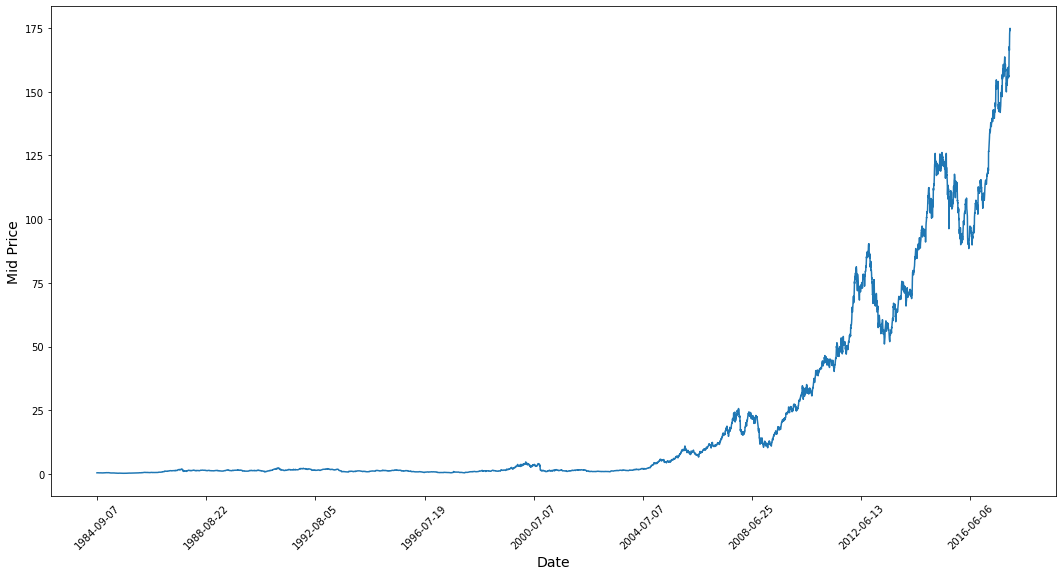

In [6]:
plt.figure(figsize=(18, 9))
sns.lineplot(range(df.shape[0]), (df['Low'] + df['High']) / 2.0)
plt.xticks(range(0, df.shape[0], 1000), df['Date'].loc[::1000], rotation=45)
plt.xlabel('Date',fontsize=14)
plt.ylabel('Mid Price',fontsize=14)
plt.show()

In [7]:
# Getting a midtrpiaces in an array
high = np.array(list(df.loc[:, 'High']))
low = np.array(list(df.loc[:, 'Low']))
mid = (high + low) / 2
print(2 * len(mid) / 3)

5576.0


In [8]:
train_data = mid[:5576]
test_data = mid[5576:]

In [9]:
scaler = MinMaxScaler()
train_data = train_data.reshape(-1, 1)
print(train_data.shape)
test_data = test_data.reshape(-1, 1)
print(test_data.shape)

(5576, 1)
(2788, 1)


In [10]:
# Skipped weird scaler stuff, will come back to this
# smoothing_window_size = 800
# for di in range(0, 8000,smoothing_window_size):
#     scaler.fit(train_data[di:di+smoothing_window_size,:])
#     train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# # You normalize the last bit of remaining data
# scaler.fit(train_data[di+smoothing_window_size:,:])
# train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [11]:
EMA = 0.0
gamma = 0.1
for t in range(5576):
    EMA = gamma * train_data[t] + (1 - gamma) * EMA
    train_data[t] = EMA

# Used for visualization and test purposes
all_mid = np.concatenate([train_data,test_data], axis=0)

In [12]:
window = 250
N = train_data.size
std_avg_pred = []
std_avg_x = []
mse_errors = []

for pred in range(window, N):
    if pred >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred, 'Date']
    
    # Add the training data for the date?
    std_avg_pred.append(np.mean(train_data[pred - window : pred]))
    # MSE adding
    mse_errors.append((std_avg_pred[-1] - train_data[pred])**2)
    # Add the dates
    std_avg_x.append(date)

print('MSE error for standard averaging: %.8f'%(0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.26537449


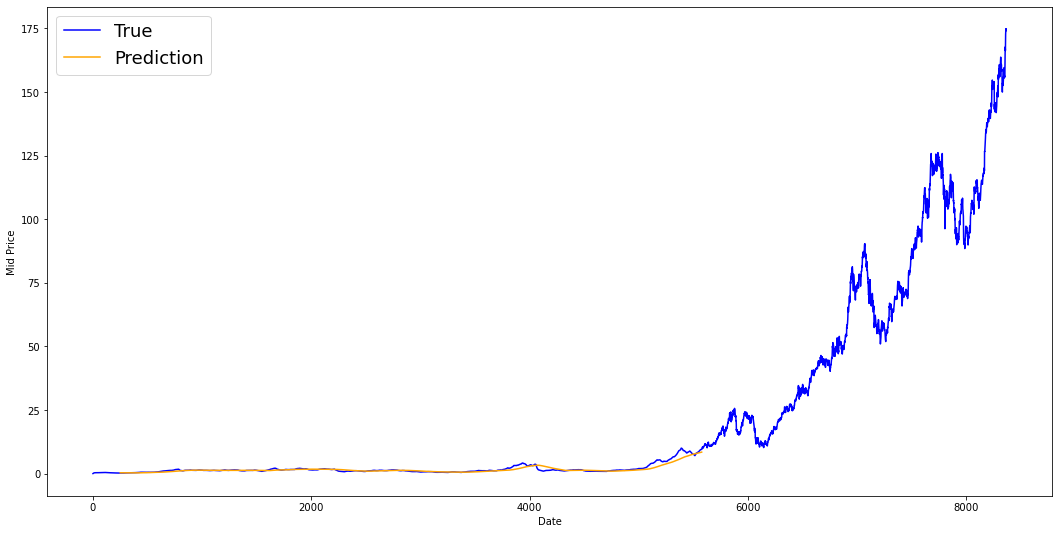

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]), all_mid, color='b',label='True')
plt.plot(range(window, N),std_avg_pred, color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [14]:
data = df.sort_index(ascending=True, axis=0)
data.head()
print(len(data))

8364


In [15]:
#setting index
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
new_data.head()

,Close
Date,
1984-09-07,0.42388
1984-09-10,0.42134
1984-09-11,0.42902
1984-09-12,0.41618
1984-09-13,0.43927


In [33]:
dataset = new_data.values
train = dataset[:-1848]
test = dataset[-1848:]
len(test)

1848

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(dataset)

In [35]:
x_train = []
y_train = []
for i in range(60, len(train)):
    x_train.append(scaled[i - 60: i, 0])
    y_train.append(scaled[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [36]:
# Create the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1)

6456/6456 [==============================] - 118s 18ms/step - loss: 3.1405e-05


In [37]:
inputs = new_data[len(new_data) - len(test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs  = scaler.transform(inputs)

In [38]:
x_test = []
for i in range(60, inputs.shape[0]):
    x_test.append(inputs[i - 60: i, 0])
x_test = np.array(x_test)

In [39]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
closing_price = model.predict(x_test)
closing_price = scaler.inverse_transform(closing_price)

In [40]:
train = new_data[:-1848]
test = new_data[-1848:]
test['Predictions'] = closing_price
test

<ipython-input-40-8220324f2e6c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = closing_price


,Close,Predictions
Date,,
2010-07-14,32.365,33.527336
2010-07-15,32.2,33.409496
2010-07-16,32.004,33.258495
2010-07-19,31.449,33.081963
2010-07-20,32.26,32.805820
...,...,...
2017-11-06,173.63,162.021088
2017-11-07,174.18,163.730698
2017-11-08,175.61,165.130783


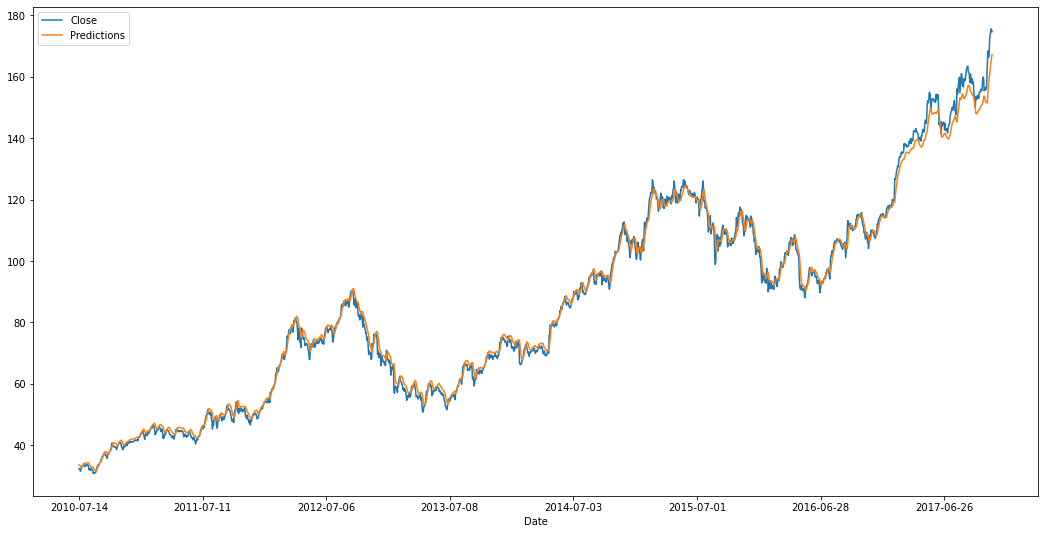

In [41]:
test.plot(figsize=(18, 9))

In [ ]:
idx = pd.date_range('2017-11-11', periods=1200, freq='D')
forward = pd.Series(range(len(idx)), index=idx)
forward = pd.DataFrame(forward)
forward.drop(0, axis=1, inplace=True)

In [ ]:
f_inputs = test.values
f_inputs = f_inputs.reshape(-1, 1)
f_inputs = scaler.transform(f_inputs)
print(f_inputs.shape)

In [ ]:
f_test = []
for i in range(f_inputs.shape[0] - 1200, f_inputs.shape[0]):
    f_test.append(f_inputs[i - 100: i, 0])
f_test = np.array(f_test)
f_test.shape

In [ ]:
f_test = np.reshape(f_test, (f_test.shape[0], f_test.shape[1], 1))
closing_price = model.predict(f_test)
closing_price = scaler.inverse_transform(closing_price)

In [ ]:
forward["Apple Price Prediction"] = closing_price

In [ ]:
apple_curr = pd.read_csv('AAPL-2.csv')

In [ ]:
test1 = pd.DataFrame(forward["Apple Price Prediction"][:781])
apple_close = np.array(apple_curr['Close']).astype(float)
test1['Real Apple Price'] = apple_close
test1

In [ ]:
test1.plot(figsize=(18, 9))